# <a id='toc1_'></a>[Subject: Advanced Artificial Intelligence, 1st October 2024 to 1st May 2025.](#toc0_)
## <a id='toc1_1_'></a>[Topic: Group Project - Developing the MARS Model](#toc0_)
## <a id='toc1_2_'></a>[Learning Outcomes](#toc0_)
1. Critically appraise competing AI-based paradigms and algorithms in the context of the issues posed by particular problems
2. Select and tune appropriate state of the art machine learning and optimisation algorithms to realistic sized problems illustrating properties such as scale, noise, missing data.
3. Synthesise, design, and implement appropriate hybrid systems blending different paradigms for complex problems.
4. Demonstrate skills in evaluating systems and presenting findings in ways appropriate to different audiences.


**Table of contents**<a id='toc0_'></a>    
- [Subject: Advanced Artificial Intelligence, 1st October 2024 to 1st May 2025.](#toc1_)    
  - [Topic: Group Project - Developing the MARS Model](#toc1_1_)    
  - [Learning Outcomes:](#toc1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# Importing the libraries

In [12]:
import sys

PATH_TO_UWE_ENTERPRISE_MLAAS_MODELS = "C:/Program Development/UWE Bristol/Year 3/Enterprise AI Project/project/backend/services/machinelearning/uwe_enterprise_mlaas_models"
sys.path.append(PATH_TO_UWE_ENTERPRISE_MLAAS_MODELS)
# %pip install -r requirements.txt
# %pip install lime
# %pip install shap
# %pip install tf2onnx
import pandas as pd
import numpy as np
import tf2onnx


In [13]:
try:
    from models import (
        DataPreprocessor,
        DataStandardizer,
        Encoder,
        Scaler,
        Imputer,
        RANDOM_STATE,
        TESTING_DATA_SIZE,
        TARGET_VARIABLE_COL_NUM,
        datasets_processed_directory,
        datasets_raw_directory,
        insurance_dataset,
        gdpr_protected_cols,
        invalid_cols,
        medical_protected_cols,
        datetime_cols,

        # Models
        MARS
    )
except ImportError:
    from models import (
        DataPreprocessor,
        DataStandardizer,
        Encoder,
        Scaler,
        Imputer,
        RANDOM_STATE,
        TESTING_DATA_SIZE,
        TARGET_VARIABLE_COL_NUM,
        datasets_processed_directory,
        datasets_raw_directory,
        insurance_dataset,
        gdpr_protected_cols,
        invalid_cols,
        medical_protected_cols,
        datetime_cols,

        # Models
        MARS
    )

from sklearn.model_selection import train_test_split

# Loading the dataset

In [14]:
print("Dataset Path: ", insurance_dataset)

data = pd.read_csv(
    insurance_dataset
)

print("Data Shape: ", data.shape)


Dataset Path:  c:\Program Development\UWE Bristol\Year 3\Enterprise AI Project\project\backend\services\machinelearning\uwe-enterprise-mlaas-models\datasets\raw\insurance.csv
Data Shape:  (5000, 36)


# Preprocessing the dataset
In this section the raw dataset is passed into a preprocessor, which uses internal functions for refactoring columns names. Moreover, each column has been imputed and encoded or scaled depending on the type of data and its use case.

```python
class DataPreprocessor(
    df: DataFrame,
    target_variable: str = None,
    protected_cols: list[str] = None
)
```

- The data preprocessor class automatically handles the preprocessing of linear/tabular data in the form of numerical, datetime, and categorical data.

In [15]:

protected_cols = (
    gdpr_protected_cols + medical_protected_cols + datetime_cols + invalid_cols
)

TARGET_VARIABLE = "SettlementValue"

# target_variable_col = data[TARGET_VARIABLE]

processor = DataPreprocessor(
    df=data,
    # target_variable=TARGET_VARIABLE,
    protected_cols=protected_cols
)

# processor.df[TARGET_VARIABLE] = target_variable_col
target = processor.df[TARGET_VARIABLE].copy()

if (target.isnull().sum() > 0):
    print("Target variable has null values")
    sys.exit(1)

print(target)

[WARNING] Missing values found. If populating value is 0, this does not always mean the existing columns are filled.
[INFO] Imputed 2640 numerical, 247 datetime, 1225 categorical values.
[INFO] Found 2 datetime columns: ['AccidentDate', 'ClaimDate']
[INFO] Found 4459 rows in 'InjuryPrognosis' that do not match the expected structure.
Encoding cyclical features: ['AccidentDateYear', 'AccidentDateMonth', 'AccidentDateDay', 'AccidentDateHour', 'ClaimDateYear', 'ClaimDateMonth', 'ClaimDateDay', 'ClaimDateHour']
Encoding cyclical features: ['PrognosisEndDateYear', 'PrognosisEndDateMonth', 'PrognosisEndDateDay', 'PrognosisEndDateHour']
0       0.054890
1       0.259481
2       0.823353
3       0.054890
4       0.002994
          ...   
4454    0.009980
4455    0.407186
4456    0.802395
4457    0.195609
4458    0.578842
Name: SettlementValue, Length: 4459, dtype: float64


c:\Program Development\UWE Bristol\Year 3\Enterprise AI Project\project\backend\services\machinelearning\uwe-enterprise-mlaas-models\models\preprocessing\preprocessor.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'AccidentClaimDeltaInDays'] = (


## Split the data into training and testing

In [16]:
df = processor.df.copy()

df = df.iloc[: 5000]  # Reduce the dataset size for time complexity
print("Data Frame Shape: ", df.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=[TARGET_VARIABLE]),
    df[TARGET_VARIABLE],
    test_size=TESTING_DATA_SIZE,
    random_state=RANDOM_STATE,
)


print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

Data Frame Shape:  (4459, 56)
X_train Shape:  (3567, 55)
y_train Shape:  (3567,)
X_test Shape:  (892, 55)
y_test Shape:  (892,)


## Check for missing data in the dataset before proceeding

In [17]:
def check_missing_values(X, y):
    """
    Checks for NaN or infinite values in X and y.

    Parameters:
        X (DataFrame): Features.
        y (Series): Target.

    Returns:
        bool: True if NaN or infinite values are found, False otherwise.
    """
    if X.isna().any().any() or y.isna().any():
        print("NaN values found in X or y.")
        return True
    if X.isin([float('inf'), float('-inf')]).any().any() or y.isin([
        float('inf'), float('-inf')
    ]).any():
        print("Infinite values found in X or y.")
        return True
    return False

missing_values = check_missing_values(X_train, y_train) or check_missing_values(X_test, y_test)
if missing_values:
    print("Missing values detected in the dataset.")
    sys.exit(1)

# Training the MARS model

## Grid Search - fit function and splitting data

In [18]:
def split_data(X, y, n_chunks):
    """
    Split the data into chunks (processors) for parallel processing.
    """
    X = np.atleast_2d(X)
    y = np.ravel(y)

    chunk_size = len(X) // n_chunks
    return [(
            X[i * chunk_size:(i + 1) * chunk_size],
            y[i * chunk_size:(i + 1) * chunk_size]
            ) for i in range(n_chunks)
    ]

### Grid Search and Model trained on CPU

In [19]:
import itertools
from joblib import Parallel, delayed

def predict(models, X):
    """
    Predict using the ensemble of models.

    Rather than averaging normally, the model can apply weights
    based on individual model performance, thus models with
    better performance should have a higher weight which improves prediction.
    """
    chunked_predictions = np.array([model.predict(X) for model in models])
    return np.mean(chunked_predictions, axis=0)

def weighted_mse(y_true, y_pred, weights):
    """
    Calculate weighted mean squared error.

    Parameters:
        y_true (ndarray): True target values.
        y_pred (ndarray): Predicted target values.
        weights (ndarray): Weights for each prediction.

    Returns:
        float: Weighted mean squared error.
    """
    squared_errors = (y_true - y_pred) ** 2
    weighted_mse = np.sum(weights * squared_errors) / np.sum(weights)
    return weighted_mse

def weighted_r2(y_true, y_pred, weights):
    """
    Calculate weighted R^2 score.

    Parameters:
        y_true (ndarray): True target values.
        y_pred (ndarray): Predicted target values.
        weights (ndarray): Weights for each prediction.

    Returns:
        float: Weighted R^2 score.
    """
    ss_res = ((y_true - y_pred) ** 2 * weights).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2 * weights).sum()
    r2 = 1 - ss_res / ss_tot
    return r2

def evaluate_ensemble(models, X_test, y_test, weights):
    """
    Evaluate the ensemble of models using weighted MSE and weighted R^2.
    """
    preds = np.mean([model.predict(X_test) for model in models], axis=0)
    mse = weighted_mse(y_test, preds, weights)
    r2 = weighted_r2(y_test, preds, weights)
    return mse, r2

def grid_search(model_class: MARS, fit_function, X_train, y_train, X_test, y_test, param_grid, n_jobs=-1):
    """
    Custom grid search with parallel processing for hyperparameter tuning.

    Parameters:
        X_train (DataFrame): Training features.
        y_train (Series): Training target variable.
        X_test (DataFrame): Testing features.
        y_test (Series): Testing target variable.
        param_grid (dict): Dictionary of hyperparameters to search.
        n_jobs (int): Number of parallel jobs. Default is -1.

    Returns:
        dict: Best parameters, their corresponding score, and the best model.
    """

    keys, values = zip(*param_grid.items())
    param_combinations = [
        dict(zip(keys, v))
        for v in itertools.product(*values)
    ]

    n_chunks = n_jobs
    data_chunks = split_data(X_train, y_train, n_chunks)
    print(f"Data chunks {len(data_chunks)}: ", [
        len(chunk) for chunk in data_chunks
    ])

    best_params = None
    avg_best_r2 = float('-inf')
    avg_best_mse = float('inf')
    best_ensemble = None
    grid_searches = []
    best_i = 0

    print(f"Combinations: {len(param_combinations)}")
    for i, params in enumerate(param_combinations):
        weights = np.ones(len(y_test))
        models = Parallel(n_jobs=n_jobs)(
            delayed(fit_function)(model_class, X_chunk, y_chunk, **params)
            for X_chunk, y_chunk in data_chunks
        )

        models = [model for model in models if model is not None]
        if not models:
            print(f"No valid models for parameters: {params}. Skipping.")
            continue

        avg_mse, avg_r2 = evaluate_ensemble(models, X_test, y_test, weights)
        print(
            f"{i}: {models[0]} - " +
            f"Weighted MSE: {avg_mse}, Weighted R^2: {avg_r2}"
        )

        grid_searches.append({
            'params': params,
            'w_mse': avg_mse,
            'w_r2': avg_r2
        })

        if avg_r2 > avg_best_r2 and avg_mse < avg_best_mse:
            avg_best_r2 = avg_r2
            avg_best_mse = avg_mse
            best_params = params
            best_ensemble = models
            best_i = i

    print(
        f"\n[{best_i}] Best Params: {best_params}" +
        f"\nWeighted MSE: {avg_best_mse}\nWeighted R^2: {avg_best_r2}"
    )
    return best_ensemble, np.array(grid_searches)

In [20]:
from models.types.experimental.mars.mars import MARS
import time

# param_grid = {
#     "max_terms": [400],
#     "max_degree": [2],
#     "min_samples_split": [4],
#     "penalty": [0.1]
# }

# param_grid = {
#     'max_terms': [100, 200, 300, 400],
#     'max_degree': [3],
#     'min_samples_split': [4, 8, 12, 16],
#     'penalty': [0.1, 0.5, 1.0]
# }

param_grid = {
    'max_terms': [100],
    'max_degree': [3],
    'min_samples_split': [4],
    'penalty': [0.1]
}

def fit_mars_model(model_class: MARS, X, y, max_terms, max_degree, min_samples_split, penalty):
    X = np.atleast_2d(X)
    y = np.ravel(y)
    model = model_class(
        max_terms=max_terms,
        max_degree=max_degree,
        min_samples_split=min_samples_split,
        penalty=penalty,
    )

    try:
        model.fit(X, y)
        print(f"Fitted model with params: {max_terms}, {max_degree}, {min_samples_split}, {penalty}")
    except Exception as e:
        print(f"Error fitting model with params: {max_terms}, {max_degree}, {min_samples_split}, {penalty}. Error: {e}")
        return None

    return model

if max(param_grid['max_terms']) <= df.shape[0]:
    start_time = time.time()
    print("Starting grid search...")
    best_ensemble, grid_searches = grid_search(
        model_class=MARS,
        fit_function=fit_mars_model,
        X_train=X_train.values,
        y_train=y_train.values,
        X_test=X_test.values,
        y_test=y_test.values,
        param_grid=param_grid,
        n_jobs=20,
    )
    end_time = time.time()
    print(f"Grid search completed in {end_time - start_time:.2f} seconds.")
else:
    print("Error: max_terms cannot be larger than the dataset rows.")
    sys.exit()


Starting grid search...
Data chunks 20:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Combinations: 1
0: MARS(max_degree=3, max_terms=100, min_samples_split=4, penalty=0.1) - Weighted MSE: 0.023508937897563018, Weighted R^2: 0.7355125219210827

[0] Best Params: {'max_terms': 100, 'max_degree': 3, 'min_samples_split': 4, 'penalty': 0.1}
Weighted MSE: 0.023508937897563018
Weighted R^2: 0.7355125219210827
Grid search completed in 1230.16 seconds.


### Grid Search and Model trained with CPU and GPU

In [ ]:
sys.exit()

from models.types.experimental.mars.mars_gpu import MARSGPU
from models.selection.grid_search import GridSearch
import cupy as cp

param_grid = {
    "max_terms": [400],
    "max_degree": [2],
    "min_samples_split": [4],
    "penalty": [0.1]
}

def fit_mars_model_gpu(model_class: MARSGPU, X, y, max_terms, max_degree, min_samples_split, penalty):
    X = cp.asarray(X)
    y = cp.asarray(y)
    model = model_class(
        max_terms=max_terms,
        max_degree=max_degree,
        min_samples_split=min_samples_split,
        penalty=penalty,
    )

    try:
        model.fit(X, y)
        print(f"Fitted model with params: {max_terms}, {max_degree}, {min_samples_split}, {penalty}")
    except Exception as e:
        print(f"Error fitting model with params: {max_terms}, {max_degree}, {min_samples_split}, {penalty}. Error: {e}")
        return None

    return model

grid_search = GridSearch()
best_ensemble, grid_searches = grid_search.grid_search(
    model_class=MARSGPU,
    fit_function=fit_mars_model_gpu,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    param_grid=param_grid,
    n_jobs=2
)

# Best Estimator Analytics

In [21]:
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X, y, metric):
    """
    Custom permutation importance function for MARS models.

    Parameters:
    model (MARS): Trained MARS model.
    X (np.ndarray): Feature matrix.
    y (np.ndarray): Target vector.
    metric (function): The metric used to evaluate the performance.

    Returns:
    list: List of tuples (feature_index, importance_score).
    """
    baseline_score = metric(y, model.predict(X))

    importances = []
    for col in range(X.shape[1]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, col])
        permuted_score = metric(y, model.predict(X_permuted))
        importance = baseline_score - permuted_score
        importances.append((col, importance))

    return sorted(importances, key=lambda x: x[1], reverse=True)

feature_names = X_test.columns
importance = permutation_importance(
    best_ensemble[0],
    X_test.values,
    y_test.values,
    mean_squared_error
)

# Replace feature indices with feature names
importance = [(feature_names[idx], score) for idx, score in importance]

# Print the feature importances
print("Feature Importances:")
spacing = 50
for feature_index, score in importance:
    feature = f"{feature_index}:"
    print(f"{feature}{' ' * (spacing - len(feature))}{score}")

Feature Importances:
PrognosisEndDateYear:                             0.000989470081715793
ClaimDateYear:                                    0.0009510279421515444
VehicleAge:                                       0.0006012131475785359
AccidentType:                                     0.0005369614553283747
AccidentDateHourSine:                             0.0004918862314886169
ClaimDateHourSine:                                0.00043556387582775746
AccidentDescription:                              0.0003086973929184167
AccidentClaimDeltaInDays:                         0.00021412578596537168
SpecialUsageLoss:                                 0.0001497866676833104
ClaimDateHourCosine:                              0.00014072882067536763
AccidentDateHourCosine:                           6.025550779510669e-05
PrognosisEndDateHourCosine:                       5.977306923102277e-05
AccidentDateMonthCosine:                          4.3643631821146944e-05
PrognosisEndDateHourSine:               

Intercept 1.4839780743528164
Prediction_local [0.37147709]
Right: 0.376789763487704


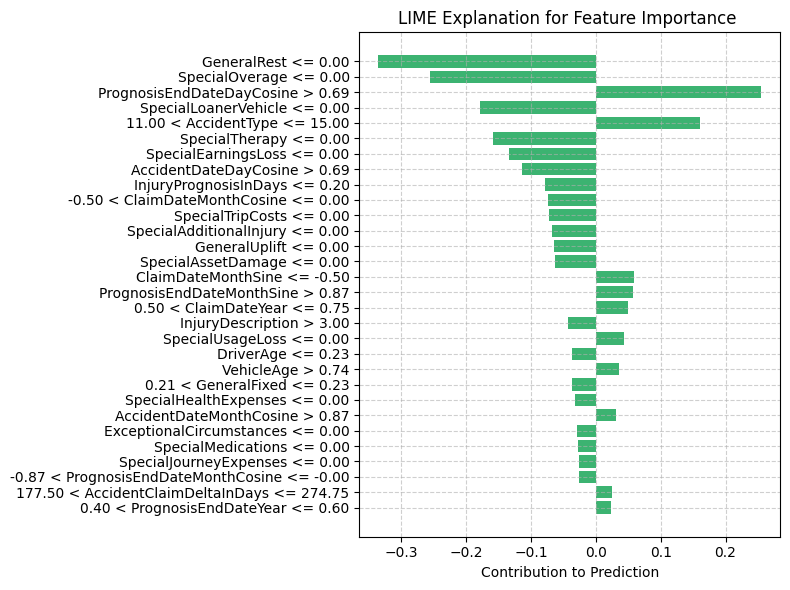

In [22]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_test.values,
    feature_names=X_test.columns.tolist(),
    mode='regression',
    verbose=True
)

exp = explainer.explain_instance(
    data_row=X_test.values[0],
    predict_fn=best_ensemble[0].predict,
    num_features=30,
    top_labels=1,
    model_regressor=None,
)

instance = X_test.values[0]
explanation = exp.as_list()
features, contributions = zip(*explanation)

plt.figure(figsize=(8, 6))
bars = plt.barh(range(len(features)), contributions, color='mediumseagreen')
plt.yticks(range(len(features)), features)
plt.xlabel('Contribution to Prediction')
plt.title('LIME Explanation for Feature Importance ')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [23]:
def ensemble_summary(self, X_test, y_test):
    """
    Generate a summary of the MARS ensemble's performance.

    Parameters:
    X_test (np.ndarray): Test feature matrix.
    y_test (np.ndarray): Test target vector.

    Returns:
    dict: A dictionary containing the ensemble's summary metrics.
    """
    if not self.basis_:
        raise ValueError("The model has not been trained yet.")

    # Aggregating results from all models in the ensemble
    terms_used = []
    gcv_values = []
    r_squared_values = []
    importance = {}

    for model in self.models:
        model_summary = model.summary(X_test, y_test)

        # Aggregate terms used
        terms_used.append(int(model_summary['selected_terms'].split(' ')[0]))

        # Aggregate GCV and R²
        gcv_values.append(model_summary["gcv"])
        r_squared_values.append(model_summary["r2"])

        # Aggregate importance (weighted by model contribution if applicable)
        for predictor, imp in model_summary["importance"].items():
            if predictor not in importance:
                importance[predictor] = []
            importance[predictor].append(imp)

    # Calculate ensemble-level metrics
    avg_terms = np.mean(terms_used)
    avg_gcv = np.mean(gcv_values)
    avg_r2 = np.mean(r_squared_values)

    # Average feature importance across all models
    avg_importance = {
        predictor: np.mean(importance[predictor]) for predictor in importance
    }

    return {
        "ensemble_terms_used": avg_terms,
        "ensemble_gcv": avg_gcv,
        "ensemble_r2": avg_r2,
        "ensemble_importance": avg_importance,
    }

## Dump the trained model for predictions

# Pickle method

In [19]:
import pickle

with open("mars_ensemble_model.pkl", "wb") as file:
    pickle.dump(best_ensemble, file)

## Run the model predictions from pickle

In [20]:
with open("mars_ensemble_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)
    # Aggregate predictions from all models in the ensemble
    predictions = [model.predict(X_test.values) for model in loaded_model]
    aggregated_predictions = np.mean(predictions, axis=0)

print(aggregated_predictions)

[ 0.15998735 -0.08801865  0.08624941  0.15705989  0.80568684  0.5390524
  0.31482327  0.30537398  0.26702712  0.3473139   0.47240783  0.27112344
  0.15072139  0.56732278  0.4702547   0.29809332  0.41751391  0.34676634
  0.07166454  0.15463687 -0.04894688  0.25170031  0.28098707  0.04101925
  0.53458257  0.78084386  0.20199496  0.36813138  0.17845262  0.41639863
  0.21024017  0.14426476  0.09399406  0.82433406  0.18877107  0.00408348
  0.82375677  0.02006335  0.41241381  0.34173828  0.73581233  0.08322162
  0.5950785   0.30465091  0.72973929  0.71904936  0.34058735  0.00789717
  0.25986292  0.58162254  0.81163667  0.46711363  0.3526788   0.26816498
  0.29285493  0.25063584  0.41298247  0.30567598  0.73776476  0.70781923
  0.6191569   0.56570671  0.73780637  0.51639593  0.55025719  0.70753479
  0.29444063  0.81575649  0.68856719  0.4386699   0.8137497   0.64432101
  0.28848111  0.92097001  0.68182566  0.02346493  0.64424965  0.26021597
  1.17737217  0.06113936  0.60370305  0.48577351  0.

In [21]:
import pandas as pd
predictions = pd.DataFrame({"SettlementValue": aggregated_predictions})
scaler = Scaler(predictions)

scaled_predictions = scaler.minmax_inverse_transform(column="SettlementValue")
print(scaled_predictions)

ValueError: No scaler found for column 'SettlementValue'.

# RMSE / MAE

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, aggregated_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test, aggregated_predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 0.1533262466036491
Mean Absolute Error (MAE): 0.10747146653061912
